In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt

from os.path import join
from matplotlib.gridspec import GridSpec

from scipy.stats import fligner, mannwhitneyu
from nilearn import plotting, datasets, surface

from ..utils import assign_region_names, plot_surfaces, jili_sidak_mc

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [6]:
sns.set(style='whitegrid', context='talk')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier'

In [7]:
crayons = sns.crayon_palette(['Aquamarine', 'Fuchsia', 
                              'Jungle Green', 'Fern'])

In [8]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [9]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data_qcd.csv"), index_col=0, header=0)

In [10]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [11]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [12]:
df[['pds_p_ss_female_category_2.baseline_year_1_arm_1',
    'pds_p_ss_male_category_2.baseline_year_1_arm_1']]
df['pds_p_ss_category_2.baseline_year_1_arm_1'] = df['pds_p_ss_female_category_2.baseline_year_1_arm_1'].fillna(0) + df['pds_p_ss_male_category_2.baseline_year_1_arm_1'].fillna(0)


In [13]:
tests = ['variance', 
         'fligner_sex',
         'fligner_puberty',
         #'fligner_puberty_4',
         #'fligner_puberty_5',
         'fligner_raceth', 
         'fligner_income', 
         'fligner_edu', 
         'fligner_marital', 
         'fligner_age', 
         #'fligner_scanner'
        ]

In [14]:
var_df = pd.read_csv(join(PROJ_DIR, 
                          OUTP_DIR, 
                          'variance_flinger.csv'), 
                     index_col=0, 
                     header=[0,1])

In [15]:
img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

In [16]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
fmri_var = img_modalities['fmri'].columns
fmri_cor_var = img_modalities['fmri'].filter(regex='_c.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns
morph = img_modalities['smri'].filter(regex='.*vol.*').columns

fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns

#morph_var = df[df['concept'] == 'macrostructure'].index
#cell_var = df[df['concept'] == 'microstructure'].index
func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

In [17]:
puberty = 'pds_p_ss_category_2.baseline_year_1_arm_1'
race = 'race_ethnicity.baseline_year_1_arm_1'
income = 'demo_comb_income_v2.baseline_year_1_arm_1'
edu = 'demo_prnt_ed_v2.baseline_year_1_arm_1'
age = 'interview_age.baseline_year_1_arm_1'
sex = 'sex.baseline_year_1_arm_1'
mri = 'mri_info_manufacturer.baseline_year_1_arm_1'
marry = "demo_prnt_marital_v2.baseline_year_1_arm_1"

## Visualizing brain heterogeneity across non-brain variables
1. Variability across all brain measures
2. Per modality
3. Across the brain
4. Across developmental variables
5. Across demographic variables

for var in var_df.index:
    for modality in img_modalities.keys():
        if var in img_modalities[modality]:
            var_df.at[var, 'modality'] = modality

In [18]:
var_df.index

Index(['smri_area_cdk_banksstslh.change_score',
       'smri_area_cdk_cdacatelh.change_score',
       'smri_area_cdk_cdmdfrlh.change_score',
       'smri_area_cdk_cuneuslh.change_score',
       'smri_area_cdk_ehinallh.change_score',
       'smri_area_cdk_fusiformlh.change_score',
       'smri_area_cdk_ifpllh.change_score',
       'smri_area_cdk_iftmlh.change_score',
       'smri_area_cdk_ihcatelh.change_score',
       'smri_area_cdk_locclh.change_score',
       ...
       'dmri_dtivol_fiberat_scsrh.change_score',
       'dmri_dtivol_fiberat_scslh.change_score',
       'dmri_dtivol_fiberat_fscsrh.change_score',
       'dmri_dtivol_fiberat_fscslh.change_score',
       'dmri_dtivol_fiberat_pscsrh.change_score',
       'dmri_dtivol_fiberat_pscslh.change_score',
       'dmri_dtivol_fiberat_sifcrh.change_score',
       'dmri_dtivol_fiberat_sifclh.change_score',
       'dmri_dtivol_fiberat_ifsfcrh.change_score',
       'dmri_dtivol_fiberat_ifsfclh.change_score'],
      dtype='object', length=

In [19]:
devt = ['fligner_age', 
        'fligner_sex',
        'fligner_puberty']
demo =  ['fligner_raceth',
         'fligner_income',
         'fligner_edu',
         'fligner_marital', 
         'fligner_scanner'
        ]

In [20]:
demo_alphas = [f'{i}_alpha' for i in demo]
devt_alphas = [f'{i}_alpha' for i in devt]

In [21]:
# build a df that categorizes measures (i.e., 'smri', 'cortical volume', 'region')
for var in var_df.index:
    #print(var)
    if 'mrisdp' in var:
        var_num = int(var.split('.')[0].split('_')[-1])
        var_df.at[var, 'modality'] = 'smri'
        var_df.at[var, 'atlas'] = 'dtx'
        if var_num <= 148:
            var_df.at[var, 'measure'] = 'thick'
        elif var_num <= 450 and var_num >= 303:
            var_df.at[var, 'measure'] = 'area'
        elif var_num < 604 and var_num >= 450:
            var_df.at[var, 'measure'] = 'vol'
        elif var_num <= 1054 and var_num >= 907:
            var_df.at[var, 'measure'] = 't1wcnt'
        elif var_num == 604:
            var_df.at[var, 'measure'] = 'gmvol'
    elif '_' in var:
        var_list = var.split('.')[0].split('_')
        var_df.at[var, 'modality'] = var_list[0]
        var_df.at[var, 'measure'] = var_list[1]
        var_df.at[var, 'atlas'] = var_list[2]
        var_df.at[var, 'region'] = '_'.join(var_list[3:])

In [22]:
var_df['atlas'].unique()

array(['cdk', 'scs', 'cortgordon', 'ngd', 'fib', 'fiberat'], dtype=object)

In [23]:
var_df = var_df[var_df['measure'] != 't1w']
var_df = var_df[var_df['measure'] != 't2w']

In [35]:
var_df['region']

smri_area_cdk_banksstslh.change_score       banksstslh
smri_area_cdk_cdacatelh.change_score         cdacatelh
smri_area_cdk_cdmdfrlh.change_score           cdmdfrlh
smri_area_cdk_cuneuslh.change_score           cuneuslh
smri_area_cdk_ehinallh.change_score           ehinallh
                                               ...    
dmri_dtivol_fiberat_pscslh.change_score         pscslh
dmri_dtivol_fiberat_sifcrh.change_score         sifcrh
dmri_dtivol_fiberat_sifclh.change_score         sifclh
dmri_dtivol_fiberat_ifsfcrh.change_score       ifsfcrh
dmri_dtivol_fiberat_ifsfclh.change_score       ifsfclh
Name: region, Length: 1477, dtype: object

In [40]:
var_df = assign_region_names(var_df)
var_df.to_csv(join(PROJ_DIR, 
                          OUTP_DIR, 
                          'variance_flinger-region_names.csv'))

In [21]:
atlases = list(np.unique(list(var_df['atlas'])))
measures = list(np.unique(list(var_df['measure'])))
#regions = list(var_df['region'].unique())
modalities = list(np.unique(list(var_df['modality'])))

concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'gmvol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd',
                     'rsirnigm', 
                     'rsirndgm',
                     'dtifa', 
                     'dtimd'
                    'dtitd', 
                     'dtild'],
            'func':['var',
                    'c',
                     'cor']}

columns = atlases + measures + modalities + list(concepts.keys())
prop_heterosked = pd.DataFrame(index=tests[1:], 
                                          columns=columns)
for category in tests[1:]:
    #print(category)
    for atlas in atlases:
        temp_df = var_df[var_df['atlas'] == atlas]
        prop_heterosked.at[category, atlas] = sum(temp_df[category]['a<0.05'] == '**') / len(temp_df.index)
    for measure in measures:
        temp_df = var_df[var_df['measure'] == measure]
        prop_heterosked.at[category, measure] = sum(temp_df[category]['a<0.05'] == '**') / len(temp_df.index)
    for modality in modalities:
        temp_df = var_df[var_df['modality'] == modality]
        prop_heterosked.at[category, modality] = sum(temp_df[category]['a<0.05'] == '**') / len(temp_df.index)
    for concept in concepts.keys():
        con_df = var_df[var_df['measure'] == concepts[concept][0]]
        for measure in concepts[concept][1:]:
            temp_df = var_df[var_df['measure'] == measure]
            con_df = pd.concat([con_df, temp_df], axis=0)
        prop = sum(con_df[category]['a<0.05'] == '**') / len(con_df.index)
        prop_heterosked.at[category, concept] = prop
prop_heterosked = prop_heterosked.T
prop_heterosked.columns = [i[8:] for i in prop_heterosked.columns]
prop_heterosked.dropna(axis=1,how='all').to_csv(join('..', OUTP_DIR,'heteroscedasticity_atlas_measures.csv'))

In [22]:
prop_heterosked.to_csv(join(PROJ_DIR, OUTP_DIR, 'proportion_heteroscedastic_brain_regions.csv'))

In [23]:
prop_hsk_demo = pd.Series()
for demo_var in demo:
    var = demo_var.split('_')[1]
    #print(var, sum(var_df[demo_var]['a<0.05'] == '**') / len(var_df.index))
    prop_hsk_demo.at[var] = sum(var_df[demo_var]['a<0.05'] == '**') / len(var_df.index)
prop_hsk_demo.to_csv(join(PROJ_DIR, OUTP_DIR, 'proportion_heteroscedastic_demographics.csv'))

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_22139/2570923596.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prop_hsk_demo = pd.Series()


regn_heterosked = pd.DataFrame(index=tests[1:], 
                                          columns=regions)
for category in tests[1:]:
    for region in regions:
        temp_df = var_df[var_df['region'] == region]
        if len(temp_df.index) > 1:
            
            num_hsk = sum(temp_df[category]['a<0.05'] == '**')
            print(region, num_hsk)
            if num_hsk >= 1:
                regn_heterosked.at[category, region] = num_hsk / len(temp_df.index)
            else:
                regn_heterosked.at[category, region] = 0
        else:
            pass

In [24]:
for i in var_df.index:
    #print(i)
    measure = var_df.loc[i]['measure']
    #print(measure)
    measure = str(measure.values[0])
    #print(measure)
    if measure in concepts['morph']:
        var_df.at[i,'concept'] = 'macrostructure'
    elif measure in concepts['cell']:
        var_df.at[i,'concept'] = 'microstructure'
    elif measure in concepts['func']:
        var_df.at[i,'concept'] = 'function'
    #elif measure in concepts['conn']:
    #    var_df.at[i,'concept'] = 'functional connectivity'

In [25]:
var_df['measure'].unique()

array(['area', 'thick', 'vol', 't1wcnt', 'var', 'c', 'cor', 'rsirni',
       'rsirnigm', 'rsirnd', 'rsirndgm', 'dtifa', 'dtimd', 'dtild',
       'dtitd', 'dtivol'], dtype=object)

regn_heterosked.T[regn_heterosked.T['fligner_scanner'] == 1].index

In [26]:
var_description = var_df[['modality', 
                          'atlas', 
                          'measure', 
                          'region', 
                          'concept']]
var_description.columns = var_description.columns.get_level_values(0)

In [27]:
hsk_sig_demo = var_description
for var in demo:
    temp_df = pd.Series(var_df[(var,'stat')], name=var)
    hsk_sig_demo = pd.concat([hsk_sig_demo, temp_df], axis=1)

In [28]:
# which measures and atlases have high proportions of heteroscedasticity across regions
#devt_short = [i[8:] for i in devt]
#g = sns.PairGrid(hsk_sig_demo, hue='concept', diag_sharey=False)
#g.map_upper(sns.scatterplot, s=15, alpha=0.5)
#g.map_lower(sns.kdeplot, shade=True, alpha=0.5)
#g.map_diag(sns.kdeplot, lw=2, shade=True)
#g.add_legend()

In [29]:
hsk_sig_devt = var_description
for var in devt:
    temp_df = pd.Series(var_df[(var,'stat')], name=var)
    hsk_sig_devt = pd.concat([hsk_sig_devt, temp_df], axis=1)

In [30]:
#demo_short = [i[8:] for i in demo]
#g = sns.PairGrid(hsk_sig_devt, hue='concept', diag_sharey=False)
#g.map_upper(sns.scatterplot, s=15, alpha=0.5)
#g.map_lower(sns.kdeplot, shade=True, alpha=0.5)
#g.map_diag(sns.kdeplot, lw=2, shade=True)
#g.add_legend()

In [31]:
func_var = list(btwn_fc) + list(wthn_fc) + list(fc_scor_var)

# Parsing variance across heteroscedastic categories


In [95]:
hetero = {'fligner_income':{
                    'var': income,
                    'levels': [(0,6), (7,8), (9,10)],
                    'strings': ['<$75k', '$75k-100k', '>$100k']},
               'fligner_scanner':{
                   'var': mri,
                   'levels': ['SIEMENS', 
                           'GE MEDICAL SYSTEMS', 
                           'Philips Medical Systems'],
                   'strings': ['Siemens', 'GE', 'Philips']},
               'fligner_edu': {
                   'var': edu, 
                   'levels': [(0,14), (15,17), 18, (19,22)],
                   'strings': ['HS/GED', 'AA/Some', 'Bach', 'Grad']}, 
               'fligner_raceth': {
                   'var': race,
                   'levels': [1,2,3,(4,5)], 
                   'strings': ['White', 'Black', 'Hisp.', 'Asian/Oth.']},
               'fligner_marital': {
                   'var': marry, 
                   'levels': [1,(2,5)], 
                   'strings': ['Married', 'Not Married']},
          'fligner_age':{
                    'var': age,
                    'levels': [(107.,112.), (113.,119.), (120.,125.), (126.,133.)],
                    'strings': ['9-9.3', '9.4-9.9', '10-10.4', '10.5-11']},
               'fligner_sex':{
                   'var': sex,
                   'levels': ['F', 'M'],
                   'strings': ['female', 'male']},
               'fligner_puberty': {
                   'var': puberty, 
                   'levels': [1., 2., 3.],
                   'strings': ['pre', 'early', 'mid']}, 
               }

In [96]:
concepts = var_df['concept'].dropna().unique()

In [2]:
var_df

NameError: name 'var_df' is not defined



 fligner_income
[(0, 6), (7, 8), (9, 10)] ['<$75k', '$75k-100k', '>$100k']
HIGHEST-----
        modality atlas measure region   concept
count        50    50      50     50        49
unique        3     6      10     49         3
top        dmri   cdk     var   fmaj  function
freq         25    20      22      2        24
LOWEST-----
        modality atlas measure    region   concept
count        50    50      50        50        50
unique        2     4       7        46         3
top      rsfmri   ngd     cor  tmpolerh  function
freq         42    38      34         3        42
(0, 6)
$75k-100k
2082
(7, 8)
>$100k
2876
(9, 10)


 fligner_scanner
['SIEMENS', 'GE MEDICAL SYSTEMS', 'Philips Medical Systems'] ['Siemens', 'GE', 'Philips']
HIGHEST-----
        modality atlas measure region         concept
count        50    50      50     50              36
unique        3     4      10     34               3
top        dmri   cdk    area   fmin  microstructure
freq         32    24      

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)




 fligner_sex
['F', 'M'] ['female', 'male']
HIGHEST-----
        modality atlas measure  region         concept
count        50    50      50      50              50
unique        3     5       7      47               3
top        smri   cdk    area  ifplrh  macrostructure
freq         25    26      14       2              33
LOWEST-----
        modality atlas measure        region   concept
count        50    50      50            50        48
unique        3     6      15            50         3
top      rsfmri   cdk     var  au_scs_cdelh  function
freq         28    15      14             1        28
F
male
4020
M


 fligner_puberty
[1.0, 2.0, 3.0] ['pre', 'early', 'mid']
HIGHEST-----
        modality atlas measure      region         concept
count        50    50      50          50              50
unique        3     5      11          49               3
top        smri   cdk     vol  parsobislh  macrostructure
freq         24    26      18           2              24
LOWEST-----

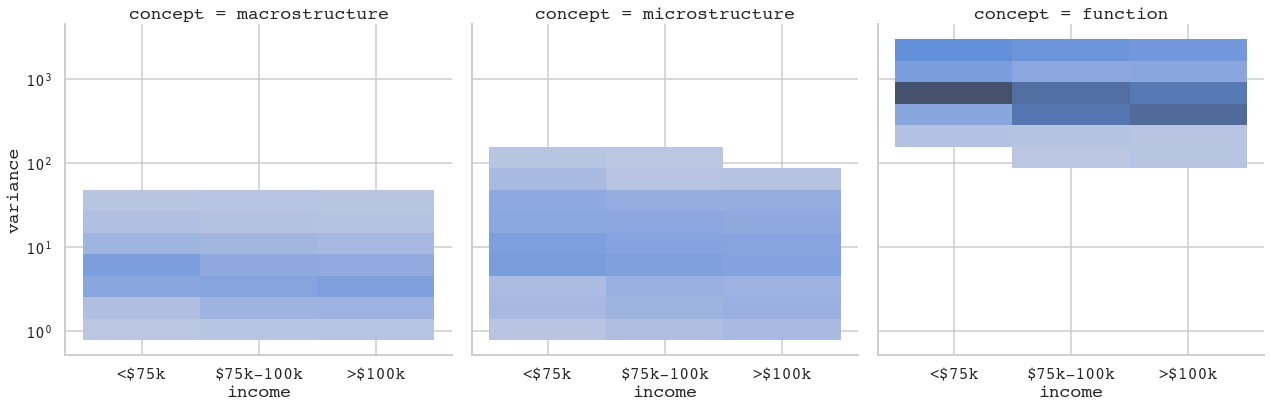

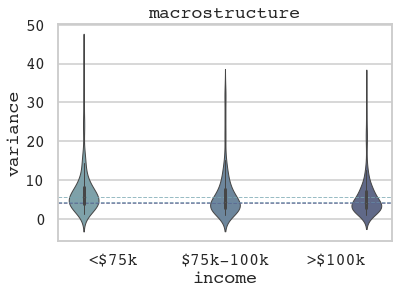

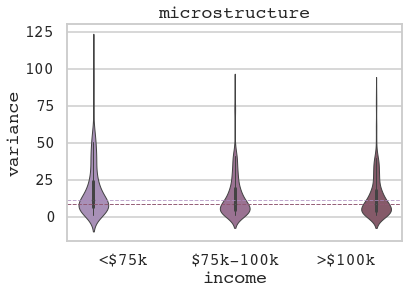

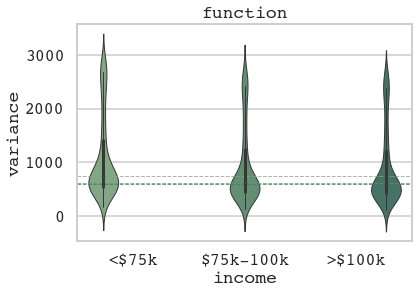

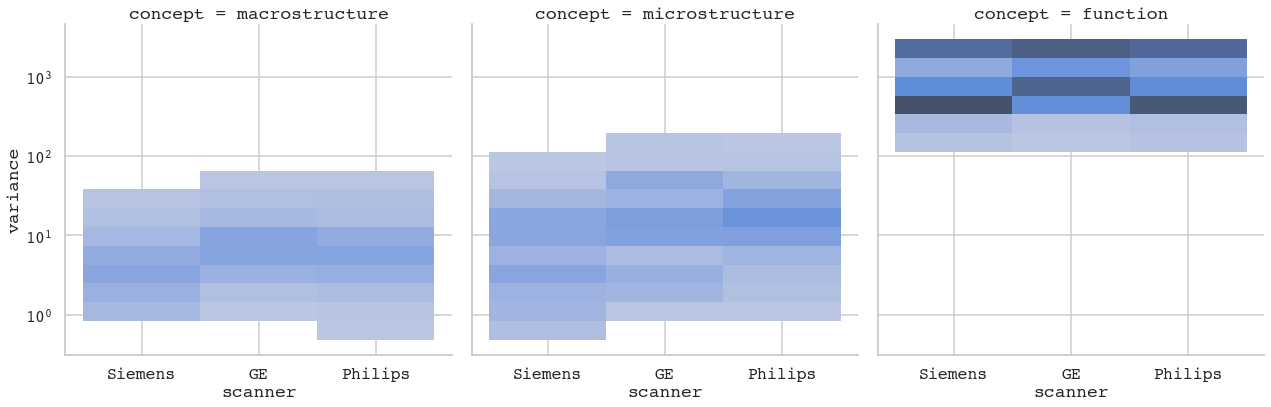

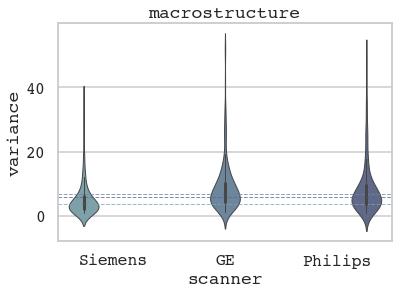

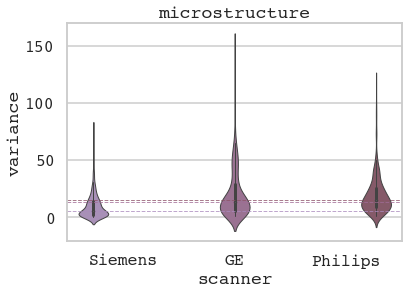

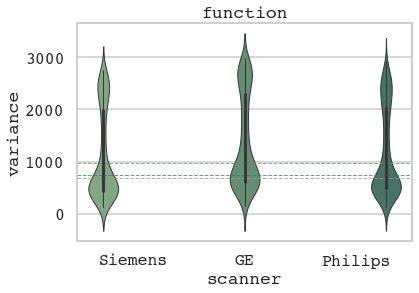

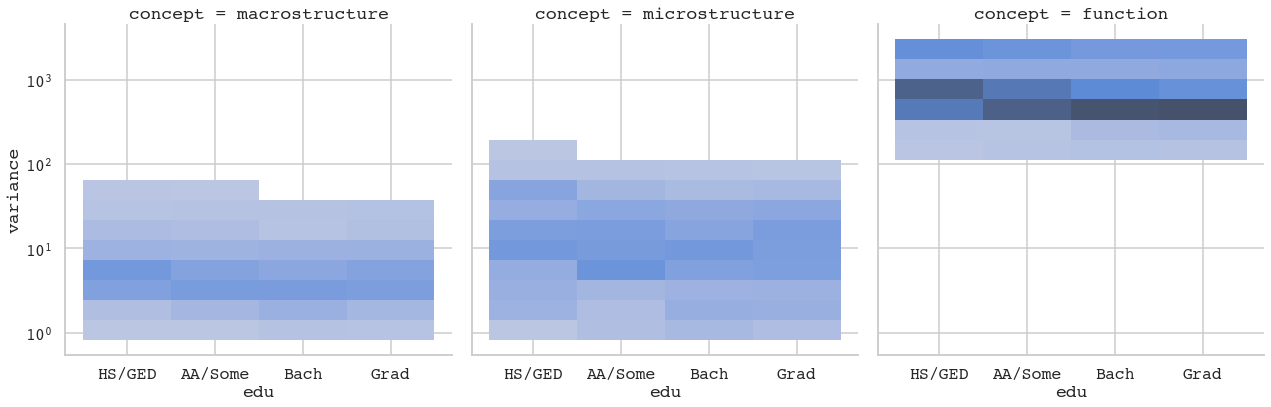

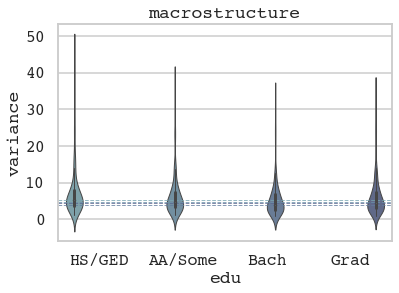

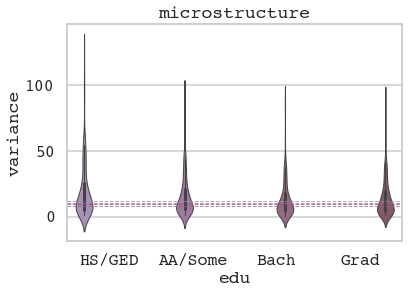

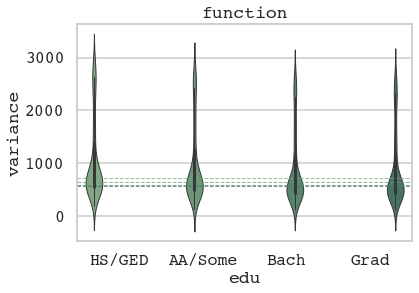

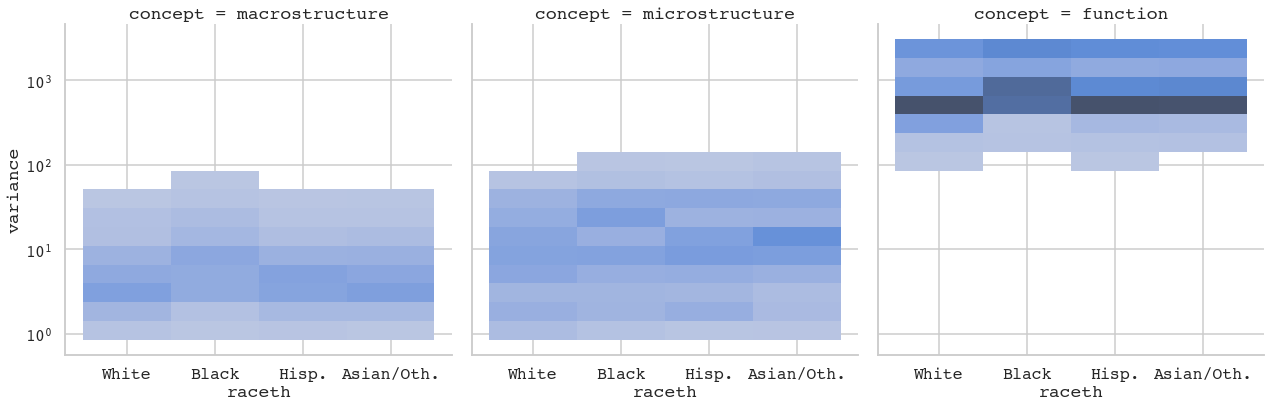

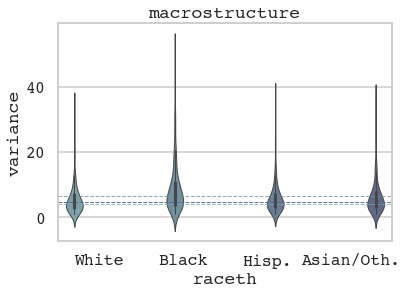

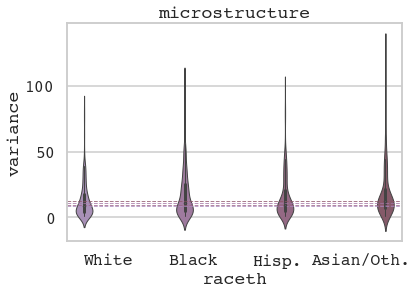

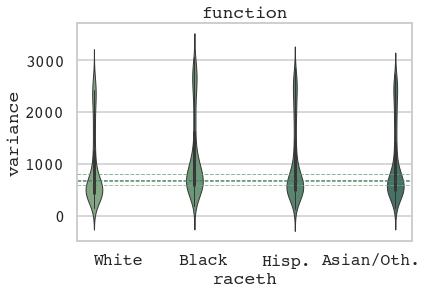

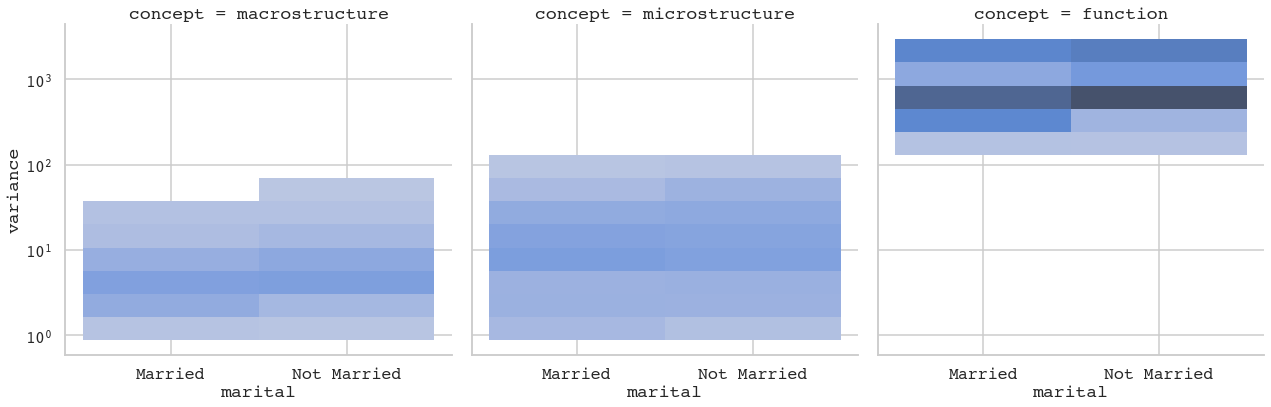

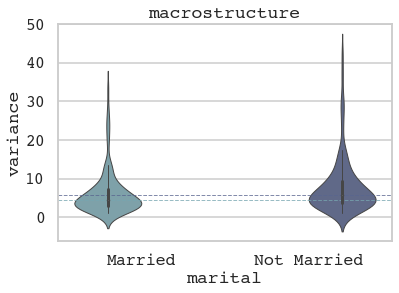

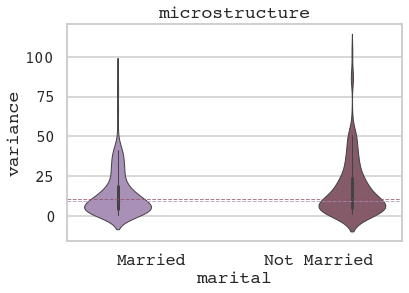

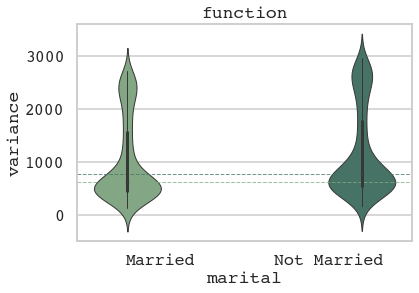

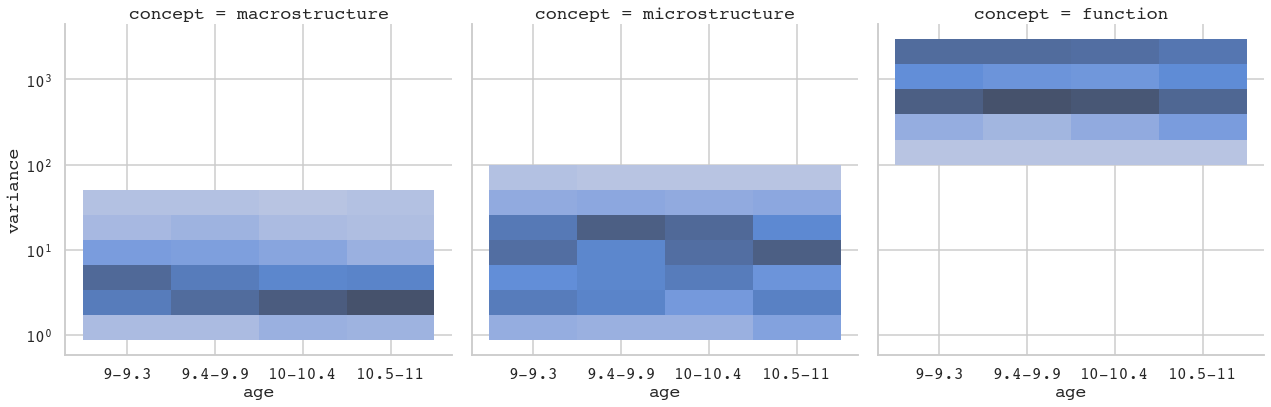

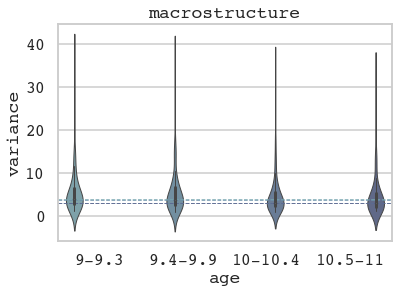

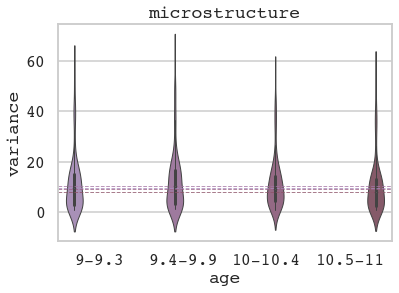

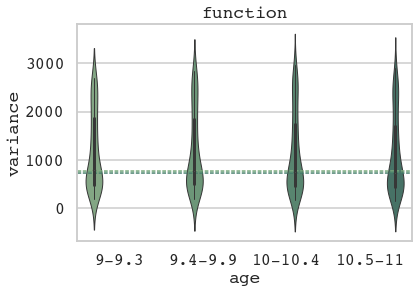

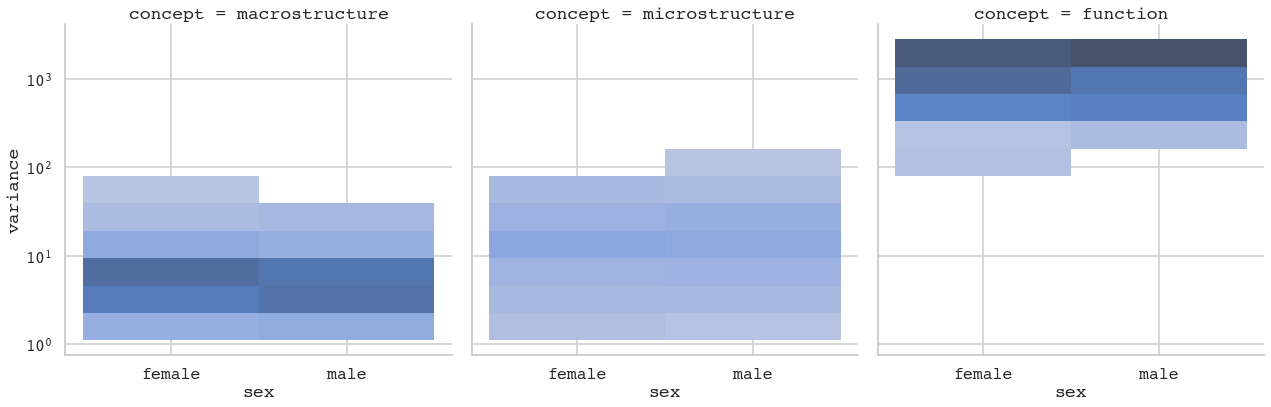

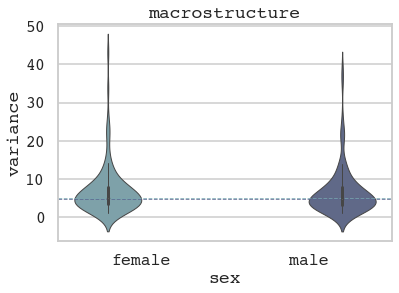

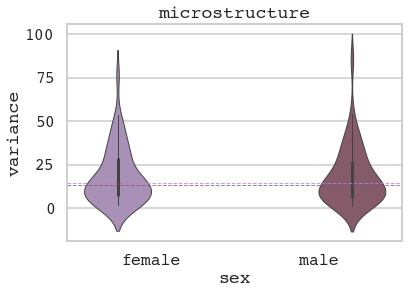

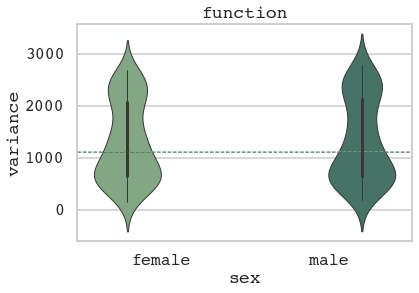

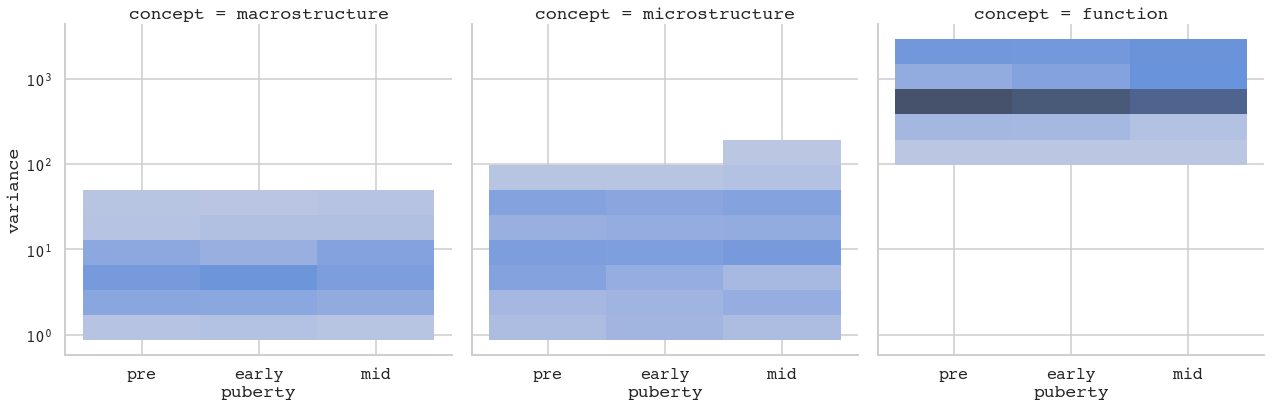

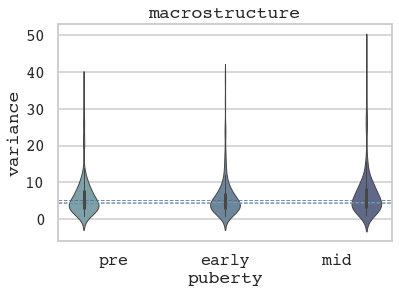

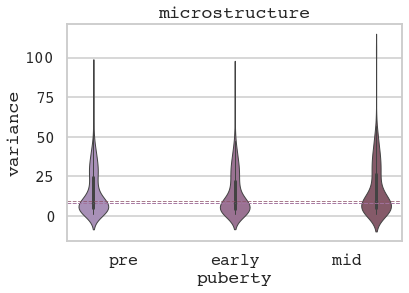

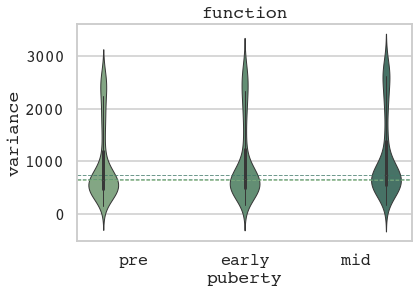

In [97]:
for fligner_var in hetero.keys():
    print('\n\n',fligner_var)
    variable = fligner_var.split('_')[-1]
    var = hetero[fligner_var]['var']
    levels = hetero[fligner_var]['levels']
    strings = hetero[fligner_var]['strings']
    print(levels, strings)
    
    sig_measures = var_df[var_df[(fligner_var, 'a<0.05')] == '**'].index
    top_50 = var_df[(fligner_var, 'stat')].sort_values()[-50:].index
    highest_heterosced = var_description.loc[top_50].describe()
    bot_50 = var_df[(fligner_var, 'stat')].sort_values()[:50].index
    lowest_heterosced = var_description.loc[bot_50].describe()
    print('HIGHEST-----\n', highest_heterosced)
    print('LOWEST-----\n', lowest_heterosced)
    
    if type(levels[0]) == int or type(levels[0]) == str or type(levels[0]) == float:
        fligner_df = df[df[var] == levels[0]]
    elif type(levels[0]) == tuple:
        it = levels[0]
        fligner_df = df[df[var].between(it[0], it[1])]
    fligner_df = pd.Series(fligner_df[var_df.index].var(), name=str(strings[0]))
    print(levels[0])

    for i in range(0, len(levels[1:])):
        level = levels[i+1]
        string = strings[i+1]
        print(string)
        if type(level) == int or type(level) == str or type(level) == float:
            temp_df = df[df[var] == level]
            print(len(temp_df.index))
        elif type(level) == tuple:
            temp_df = df[df[var].between(level[0], level[1])]
            print(len(temp_df.index))
        print(level)
        temp_df = pd.Series(temp_df[var_df.index].var(), name=string)
        fligner_df = pd.concat([temp_df, fligner_df], axis=1)
    #fligner_df = fligner_df.dropna(thresh=len(levels) - 1)
    #top_50_df = fligner_df.loc[top_50]
    #not_present = list(set(levels) - set(fligner_df.columns))
    stats = ['stat', 'pval']
    columns = pd.MultiIndex.from_product([stats, concepts + 'all'])
    mann_whitney_u = pd.DataFrame(columns=columns)
    for string in strings:
        dat = fligner_df[string].dropna()
        for string1 in strings:
            dat1 = fligner_df[string1].dropna()
            if string != string1:
                if len(dat.index) > 0 and len(dat1.index) > 0:
                    res = mannwhitneyu(dat, dat1, alternative='greater')
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'stat')] = res.statistic
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'pval')] = res.pvalue
                else:
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'stat')] = np.nan
                    mann_whitney_u.at[f'{string} > {string1}', ('all', 'pval')] = np.nan
            else:
                pass
    mann_whitney_u.to_csv(join('..', OUTP_DIR,f'mann_whitney_{variable}-variance_diff.csv'))
    #convert from variance to coefficient of variation (sdev / mean)
    heteroskedasticity = pd.Series(var_df[(fligner_var, 'stat'),(fligner_var, 'stat')], 
                                   name='heteroscedasticity')
    fligner_cov = np.sqrt(fligner_df) / fligner_df.mean(axis=0)
    fligner_cov = pd.concat([fligner_cov, var_description], axis=1)
    fligner_df = pd.concat([fligner_df, 
                            heteroskedasticity, 
                            var_description], axis=1)
    fligner_df.to_csv(join(PROJ_DIR, OUTP_DIR,f'heteroscedasticity_{variable}.csv'))
    
    str_levels = [str(level) for level in levels]
    long_fligner = fligner_df.loc[sig_measures].melt(value_vars=strings, 
                                    value_name='variance',
                                    var_name=variable,
                                    id_vars=var_description.columns)
    #long_fligner2 = fligner_cov.loc[sig_measures].melt(value_vars=strings, 
    #                                value_name='coeff_of_var',
    #                                var_name=variable,
    #                                id_vars=var_description.columns)
    fligner_df = None
    #k = sns.displot(
    #    data=long_fligner2,
    #    x=variable, y="coeff_of_var", col="concept",
    #    #col_order=, 
    #    log_scale=(False, True),
    #    #col_wrap=4, height=4, aspect=0.9,
    #    height=6, 
    #)
    #k.savefig(join('..', 
    #               FIGS_DIR, 
    #              f'heteroscedastic_{variable}_coefficient-of-variation.png'), dpi=500)
    
    k = sns.displot(
        data=long_fligner,
        x=variable, y="variance", col="concept", 
        log_scale=(False, True),
        #col_wrap=4, aspect=0.9,
        height=6, 
    )
    n_colors = len(np.unique(long_fligner[variable]))
    morph_pal = sns.cubehelix_palette(n_colors=n_colors, start=0.6, rot=-0.6, 
                                      gamma=1.0, hue=0.7, light=0.6, dark=0.4)
    cell_pal = sns.cubehelix_palette(n_colors=n_colors, start=1.7, rot=-0.8, 
                                     gamma=1.0, hue=0.7, light=0.6, dark=0.4)
    func_pal = sns.cubehelix_palette(n_colors=n_colors, start=3.0, rot=-0.6, 
                                     gamma=1.0, hue=0.7, light=0.6, dark=0.4)
    
    fig,ax = plt.subplots()
    #plt.tight_layout(w_pad=1)
    #g = sns.stripplot(x=variable, y="variance", hue=variable, 
    #                  alpha=0.25, dodge=True, marker='+',
    #               data=long_fligner[long_fligner['concept'] == 'macrostructure'], 
    #                   linewidth=1, palette=morph_pal, ax=ax)
    for k in range(0,len(hetero[fligner_var]['strings'])):
        key = hetero[fligner_var]['strings'][k]
        color = morph_pal[k]
        temp_df = long_fligner[long_fligner['concept'] == 'macrostructure']
        variance = temp_df[temp_df[fligner_var.split('_')[-1]] == key]['variance']
        mean = np.median(variance)
        ax.axhline(mean, lw=1, color=tuple(color), ls='--', alpha=0.75)
    h = sns.violinplot(x=variable, y="variance", hue=variable, 
                      inner='box', 
                   data=long_fligner[long_fligner['concept'] == 'macrostructure'], 
                       linewidth=1, palette=morph_pal, ax=ax)
    # compute means
    
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    ax.legend().set_visible(False)
    ax.set_title('macrostructure')
    fig.savefig(join(PROJ_DIR,
                   FIGS_DIR,
                   f'{variable}-macro_variance.png'), dpi=500, bbox_inches='tight')
    fig,ax = plt.subplots()
    #plt.tight_layout(w_pad=1)
    h = sns.violinplot(x=variable, y="variance", hue=variable, 
                      inner='box', 
                   data=long_fligner[long_fligner['concept'] == 'microstructure'], 
                       linewidth=1, palette=cell_pal, ax=ax)
    for k in range(0,len(hetero[fligner_var]['strings'])):
        key = hetero[fligner_var]['strings'][k]
        color = cell_pal[k]
        temp_df = long_fligner[long_fligner['concept'] == 'microstructure']
        variance = temp_df[temp_df[fligner_var.split('_')[-1]] == key]['variance']
        mean = np.median(variance)
        ax.axhline(mean, lw=1, color=tuple(color), ls='--', alpha=0.75)
    #h = sns.pointplot(x=variable, y="variance", hue=variable, 
    #                  markers='x',
    #                  join=True,
    #                  data=long_fligner[long_fligner['concept'] == 'microstructure'],
    #                  linewidth=1, 
    #                  palette=cell_pal, ax=ax)
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    ax.legend().set_visible(False)
    ax.set_title('microstructure')
    fig.savefig(join(PROJ_DIR,
                   FIGS_DIR,
                   f'{variable}-micro_variance.png'), dpi=500, bbox_inches='tight')
    #fig,ax = plt.subplots()
    #plt.tight_layout(w_pad=1)
    #g = sns.boxenplot(x=variable, y="variance", hue=variable,
    #               data=long_fligner[long_fligner['concept'] == 'function'], 
    #                   linewidth=1, palette=palette, ax=ax)
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    #ax.legend().set_visible(False)
    #ax.set_title('function')
    #fig.savefig(join('..',
    #               FIGS_DIR,
    #               f'{variable}-fxn_variance.png'), dpi=500, bbox_inches='tight')
    fig,ax = plt.subplots()
    #plt.tight_layout(w_pad=5)
    for k in range(0,len(hetero[fligner_var]['strings'])):
        key = hetero[fligner_var]['strings'][k]
        color = func_pal[k]
        temp_df = long_fligner[long_fligner['concept'] == 'function']
        variance = temp_df[temp_df[fligner_var.split('_')[-1]] == key]['variance']
        mean = np.median(variance)
        ax.axhline(mean, lw=1, color=tuple(color), ls='--', alpha=0.75)
    h = sns.violinplot(x=variable, y="variance", hue=variable, 
                      inner='box', 
                   data=long_fligner[long_fligner['concept'] == 'function'], 
                       linewidth=1, palette=func_pal, ax=ax)
    #ax.set(yscale="log", #ylim=(1,10000)
    #      )
    #ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    ax.legend().set_visible(False)
    ax.set_title('function')
    fig.savefig(join(PROJ_DIR,
                   FIGS_DIR,
                   f'{variable}-func_variance.png'), dpi=500, bbox_inches='tight')

In [90]:
key = hetero[fligner_var]['strings'][k]
color = morph_pal[k]
temp_df = long_fligner[long_fligner['concept'] == 'macrostructure']
variance = temp_df[temp_df[fligner_var.split('_')[-1]] == key]['variance']
np.median(variance)
#ax.axhline(mean, lw=1, color='#333333', ls='--')

3.7705501948053635

In [34]:
for i in var_df.index:
    if i in btwn_fc:
        var_df.at[i, 'measure'] = 'between-network fc'
    elif i in wthn_fc:
        var_df.at[i, 'measure'] = 'within-network fc'
    elif i in fc_scor_var:
        var_df.at[i, 'measure'] = 'subcortical-network fc'

In [35]:
# let's visualize this variability!
destrieux = datasets.fetch_atlas_destrieux_2009()
desikan = datasets.fetch_neurovault_ids(image_ids=(23262, ))
subcort = datasets.fetch_atlas_harvard_oxford('sub-maxprob-thr50-2mm')

Reading local neurovault data.
Already fetched 1 image
1 image found on local disk.


/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/numpy/lib/npyio.py:2405: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [36]:
scs_1 = ['x',
         'x',
         'x',
         'x',
        "tplh",
        "caudatelh",
        "putamenlh",
        "pallidumlh",
        "bstem",
        "hpuslh",
        "amygdalalh",
        "aal",
        'x',
        'x',
         'x',
        "tprh",
        "caudaterh",
        "putamenrh",
        "pallidumrh",
        "hpusrh",
        "amygdalarh",
        "aar"]

In [37]:
abcd_to_harvox = pd.DataFrame(columns=['label', 'Volume', 
                                       'T1w Intensity', 
                                       'Restricted Normalized Directional Diffusion', 
                                       'Restricted Normalized Isotropic Diffusion'])

for i in range(0, len(subcort.labels)):
    label = subcort.labels[i]
    abcd_to_harvox.at[i, 'label'] = label
    if scs_1[i] == 'x':
        abcd_to_harvox.at[i, 'Volume'] = np.nan
        abcd_to_harvox.at[i, 'T1w Intensity'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = np.nan
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = np.nan
    else:
        abcd_to_harvox.at[i, 'Volume'] = f'smri_vol_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'T1w Intensity'] = f'smri_t1w_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Directional Diffusion'] = f'dmri_rsirnd_scs_{scs_1[i]}'
        abcd_to_harvox.at[i, 'Restricted Normalized Isotropic Diffusion'] = f'dmri_rsirni_scs_{scs_1[i]}'

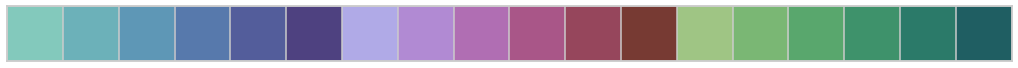

In [38]:
morph_pal = sns.cubehelix_palette(start=0.6, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
morph_cmap = sns.cubehelix_palette(n_colors=4, start=0.6, rot=-0.6, gamma=1.0, hue=0.7, light=1, dark=0.2, 
                                   as_cmap=True, reverse=True)
cell_pal = sns.cubehelix_palette(start=1.7, rot=-0.8, gamma=1.0, hue=1, light=0.7, dark=0.3)
cell_cmap = sns.cubehelix_palette(n_colors=7, start=1.7, rot=-0.8, gamma=1.0, hue=0.7, light=0.5, dark=0.2, 
                                  as_cmap=True, reverse=True)
func_pal = sns.cubehelix_palette(start=3.0, rot=-0.6, gamma=1.0, hue=1, light=0.7, dark=0.3)
func_cmap = sns.cubehelix_palette(n_colors=4, start=3.0, rot=-0.6, gamma=1.0, hue=0.7, light=0.6, dark=0.2, 
                                  as_cmap=True, reverse=True)
big_pal = morph_pal + cell_pal + func_pal
sns.palplot(big_pal)

In [39]:
abcd_to_harvox.columns[1:]

Index(['Volume', 'T1w Intensity',
       'Restricted Normalized Directional Diffusion',
       'Restricted Normalized Isotropic Diffusion'],
      dtype='object')

sc_array = subcort.filename.get_fdata()
for column in abcd_to_harvox.columns[1:]:
    plotting_arr = np.zeros(sc_array.shape)
    for i in abcd_to_harvox.index:
        abcd_var = abcd_to_harvox.loc[i, column]
        if column == 'Volume':
            plotted_vars.append(f'{abcd_var}.change_score')
        else:
            pass
        if abcd_var is np.nan:
            pass
        else:
            plotting_arr[np.where(sc_array == i)] = var_df.at[f'{abcd_var}.change_score',('variance', 'stat')]
    smri_vol_var_nimg = nib.Nifti1Image(plotting_arr, subcort.filename.affine)
    grid_kw = dict(width_ratios=[10,1])
    plt.figure(layout='tight')
    fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
    q = plotting.plot_stat_map(smri_vol_var_nimg, display_mode='z', 
                           cut_coords=[-20, -15, -10, -5, 0, 5, 10, 15], 
                           annotate=False, cmap='gist_rainbow', colorbar=False, title=column,
                           vmax=30., symmetric_cbar=False, threshold=0.1, axes=ax[0])

    ax[1].set_visible(False)
    q.savefig(f'../figures/{column}_variance.png', dpi=400)

In [40]:
fsaverage = datasets.fetch_surf_fsaverage()

In [41]:
nifti_mapping = pd.read_csv(join(PROJ_DIR, 
                                 DATA_DIR, 
                                 'variable_to_nifti_mapping.csv'), 
                            header=0, 
                            index_col=0)

In [42]:
vol_mapping = {'smri_vol_cdk_banksstslh.change_score': 1001.0,
    'smri_vol_cdk_cdacatelh.change_score': 1002.0,
    'smri_vol_cdk_cdmdfrlh.change_score': 1003.0,
    'smri_vol_cdk_cuneuslh.change_score': 1005.0,
    'smri_vol_cdk_ehinallh.change_score': 1006.0,
    'smri_vol_cdk_fusiformlh.change_score': 1007.0,
    'smri_vol_cdk_ifpllh.change_score': 1008.0,
    'smri_vol_cdk_iftmlh.change_score': 1009.0,
    'smri_vol_cdk_ihcatelh.change_score': 1010.0,
    'smri_vol_cdk_locclh.change_score': 1011.0,
    'smri_vol_cdk_lobfrlh.change_score': 1012.0,
    'smri_vol_cdk_linguallh.change_score': 1013.0,
    'smri_vol_cdk_mobfrlh.change_score': 1014.0,
    'smri_vol_cdk_mdtmlh.change_score': 1015.0,
    'smri_vol_cdk_parahpallh.change_score': 1016.0,
    'smri_vol_cdk_paracnlh.change_score': 1017.0,
    'smri_vol_cdk_parsopclh.change_score': 1018.0,
    'smri_vol_cdk_parsobislh.change_score': 1019.0,
    'smri_vol_cdk_parstgrislh.change_score': 1020.0,
    'smri_vol_cdk_pericclh.change_score': 1021.0,
    'smri_vol_cdk_postcnlh.change_score': 1022.0,
    'smri_vol_cdk_ptcatelh.change_score': 1023.0,
    'smri_vol_cdk_precnlh.change_score': 1024.0,
    'smri_vol_cdk_pclh.change_score': 1025.0,
    'smri_vol_cdk_rracatelh.change_score': 1026.0,
    'smri_vol_cdk_rrmdfrlh.change_score': 1027.0,
    'smri_vol_cdk_sufrlh.change_score': 1028.0,
    'smri_vol_cdk_supllh.change_score': 1029.0,
    'smri_vol_cdk_sutmlh.change_score': 1030.0,
    'smri_vol_cdk_smlh.change_score': 1031.0,
    'smri_vol_cdk_frpolelh.change_score': 1032.0,
    'smri_vol_cdk_tmpolelh.change_score': 1033.0,
    'smri_vol_cdk_trvtmlh.change_score': 1034.0,
    'smri_vol_cdk_insulalh.change_score': 1035.0,
    'smri_vol_cdk_banksstsrh.change_score': 2001.0,
    'smri_vol_cdk_cdacaterh.change_score': 2002.0,
    'smri_vol_cdk_cdmdfrrh.change_score': 2003.0,
    'smri_vol_cdk_cuneusrh.change_score': 2005.0,
    'smri_vol_cdk_ehinalrh.change_score': 2006.0,
    'smri_vol_cdk_fusiformrh.change_score': 2007.0,
    'smri_vol_cdk_ifplrh.change_score': 2008.0,
    'smri_vol_cdk_iftmrh.change_score': 2009.0,
    'smri_vol_cdk_ihcaterh.change_score': 2010.0,
    'smri_vol_cdk_loccrh.change_score': 2011.0,
    'smri_vol_cdk_lobfrrh.change_score': 2012.0,
    'smri_vol_cdk_lingualrh.change_score': 2013.0,
    'smri_vol_cdk_mobfrrh.change_score': 2014.0,
    'smri_vol_cdk_mdtmrh.change_score': 2015.0,
    'smri_vol_cdk_parahpalrh.change_score': 2016.0,
    'smri_vol_cdk_paracnrh.change_score': 2017.0,
    'smri_vol_cdk_parsopcrh.change_score': 2018.0,
    'smri_vol_cdk_parsobisrh.change_score': 2019.0,
    'smri_vol_cdk_parstgrisrh.change_score': 2020.0,
    'smri_vol_cdk_periccrh.change_score': 2021.0,
    'smri_vol_cdk_postcnrh.change_score': 2022.0,
    'smri_vol_cdk_ptcaterh.change_score': 2023.0,
    'smri_vol_cdk_precnrh.change_score': 2024.0,
    'smri_vol_cdk_pcrh.change_score': 2025.0,
    'smri_vol_cdk_rracaterh.change_score': 2026.0,
    'smri_vol_cdk_rrmdfrrh.change_score': 2027.0,
    'smri_vol_cdk_sufrrh.change_score': 2028.0,
    'smri_vol_cdk_suplrh.change_score': 2029.0,
    'smri_vol_cdk_sutmrh.change_score': 2030.0,
    'smri_vol_cdk_smrh.change_score': 2031.0,
    'smri_vol_cdk_frpolerh.change_score': 2032.0,
    'smri_vol_cdk_tmpolerh.change_score': 2033.0,
    'smri_vol_cdk_trvtmrh.change_score': 2034.0,
    'smri_vol_cdk_insularh.change_score': 2035.0,}

In [43]:
for vol_var in vol_mapping.keys():
    var = vol_var.split('.')[0]
    nifti_mapping.at[var,'atlas_value'] = vol_mapping[vol_var]

In [45]:
# list of measures to plot
measures = {'cortical-thickness': 'smri_thick_cdk_*',
            'cortical-gwcontrast': 'smri_t1wcnt_cdk_*',
            'cortical-area': 'smri_area_cdk_.*',
            'cortical-volume': 'smri_vol_cdk_.*', 
            'subcortical-volume': 'smri_vol_scs_.*', 
            'subcortical-RND': 'dmri_rsirnd_scs_.*',
            'subcortical-RNI': 'dmri_rsirni_scs_.*',
            'cortical-RND': 'dmri_rsirndgm_.*',
            'cortical-RNI': 'dmri_rsirnigm_.*',
            'cortical-BOLD-variance': 'rsfmri_var_cdk_.*'}
tract_measures = {'tract-volume': 'dmri_dtivol_fiberat_.*', 
            'tract-FA': 'dmri_dtifa_fiberat_.*', 
            'tract-MD': 'dmri_dtimd_fiberat_.*',
            'tract-LD': 'dmri_dtild_fiberat_.*', 
            'tract-TD': 'dmri_dtitd_fiberat_.*', 
            'tract-RND': 'dmri_rsirnd_fib_.*',
            'tract-RNI': 'dmri_rsirni_fib_.*'}
vmax = 40
#cmap = 'viridis'

conn_measures = {'cortical-network-connectivity': 'rsfmri_c_ngd_.*',
            'subcortical-network-connectivity': 'rsfmri_cor_ngd_.*_scs_.*',}

morph_cmap = sns.diverging_palette(250, 256.3, s=80, l=55, center="dark", as_cmap=True)
func_cmap = sns.diverging_palette(250, 140.9, s=80, l=55, center="dark", as_cmap=True)
cell_cmap = sns.diverging_palette(250, 294.3, s=80, l=55, center="dark", as_cmap=True)
cell_pal = sns.diverging_palette(250, 294.3, s=80, l=55, center="dark", as_cmap=False)

pals = {'cortical-thickness': morph_cmap,
        'cortical-gwcontrast': cell_cmap,
            'cortical-area': morph_cmap,
            'cortical-volume': morph_cmap, 
            'subcortical-volume': morph_cmap, 
            'subcortical-RND': cell_cmap,
            'subcortical-RNI': cell_cmap,
            'cortical-RND': cell_cmap,
            'cortical-RNI': cell_cmap,
            'cortical-BOLD-variance': func_cmap,
            'tract-volume': morph_cmap, 
            'tract-FA': cell_cmap, 
            'tract-MD': cell_cmap, 
            'tract-RND': cell_cmap,
            'tract-RNI': cell_cmap,
        'cortical-network-connectivity': func_cmap,
            'subcortical-network-connectivity': func_cmap}

In [ ]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
# separate wm and gm rsi
rsi_gm = list(img_modalities['rsi'].filter(regex='.*gm').columns) + list(img_modalities['rsi'].filter(regex='.*scs').columns)
rsi_wm = list(set(rsi_var) - set(rsi_gm))
fmri_var = img_modalities['fmri'].columns
fc_cort_var = img_modalities['fmri'].filter(regex='_c_.*').columns
fc_scor_var = img_modalities['fmri'].filter(regex='_cor_.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns


func_var = list(fmri_var_var) 
conn_var = list(fc_cort_var) + list(fc_scor_var)

btwn_fc = []
wthn_fc = []
for var in fc_cort_var:
    var_list = var[:-13].split('_')
    #print(var_list)
    if var_list[3] == var_list[5]:
        #print(var, 'within-network')
        wthn_fc.append(var)
    else:
        btwn_fc.append(var)
        #print(var, 'between-network')

In [ ]:
# test run plotting wm tracts not on a t1 (until I can get them properly registered)

for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1] 
    for measure in tract_measures.keys():
        fibers = nifti_mapping.filter(regex=tract_measures[measure], axis=0).index
        var = fibers[0]
        tract_fname = nifti_mapping.loc[var]['atlas_fname']
        tract_nii = nib.load(tract_fname)
        tract_arr = tract_nii.get_fdata()
        #print(np.unique(tract_arr))
        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
        all_tracts_arr = np.zeros(tract_arr.shape)
        all_tracts_arr += tract_arr
        for var in fibers[1:]:    
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            if type(tract_fname) is str:
                try:
                    tract_nii = nib.load(tract_fname)
                    tract_arr = tract_nii.get_fdata()
                    #print(np.unique(tract_arr))
                    if var_df.at[f'{var}.change_score',(fligner_var, 'a<0.05')] == '**':
                        tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
                    else:
                        tract_arr *= 0
                    all_tracts_arr += tract_arr
                except Exception as e:
                    pass
            else:
                pass
        meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
        plt.figure(layout='tight')
        #fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
        q = plotting.plot_glass_brain(meas_nimg, display_mode='z',  
                                   vmax=vmax*1.1, 
                                vmin=-vmax*1.1,
                                   annotate=False, cmap=pals[measure], colorbar=False,
                                   #axes=ax[0]
                              )
        #q.add_edges(meas_nimg)
        q.savefig(f'../figures/{fligner}x{measure}_fk.png', dpi=400)
        q = None

In [ ]:
for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1]
    for measure in measures:
        print(measure)
        meas_df = var_df.filter(regex=measures[measure], axis=0)
        print(len(meas_df.index))
        meas_vars = [i.split('.')[0] for i in meas_df.index]
        atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
        print(atlas_fname)
        atlas_nii = nib.load(atlas_fname)
        atlas_arr = atlas_nii.get_fdata()
        plotting_arr = np.zeros(atlas_arr.shape)
        sig = 0
        for i in meas_df.index:
            if 'cdk_total' in i:
                pass
            else:
                j = i.split('.')[0]
                value = nifti_mapping.loc[j]['atlas_value']
                #print(i, value)
                if value is np.nan:
                    pass
                else:
                    if var_df.at[i,(fligner_var, 'a<0.05')] == '**':
                        sig += 1
                        plotting_arr[np.where(atlas_arr == value)] = var_df.at[i,(fligner_var, 'stat')]
                    else:
                        plotting_arr[np.where(atlas_arr == value)] = 0
        print('plotting...', f'{sig} out of {len(meas_df.index)} heteroskedastic regions\n avg val: {np.mean(plotting_arr)}')
        meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
        if 'subcortical' in measure:
            grid_kw = dict(width_ratios=[3,1])
            
            fig,ax = plt.subplots(#ncols=2, gridspec_kw=grid_kw, figsize=(24,4)
                                 )
            plt.figure(layout='tight')
            q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=1,
                                   cut_coords=[-20, -10, 0, 10], vmax=vmax*1.1, 
                                   annotate=False, cmap=pals[measure], colorbar=False,
                                   symmetric_cbar=False, axes=ax)

            #ax[1].set_visible(False)
            q.savefig(f'../figures/{fligner}x{measure}_fk_scs.png', dpi=400)
        elif measure in tract_measures.keys():
            fibers = nifti_mapping.filter(regex=tract_measures[measure], axis=0).index
            var = fibers[0]
            tract_fname = nifti_mapping.loc[var]['atlas_fname']
            tract_nii = nib.load(tract_fname)
            tract_arr = tract_nii.get_fdata()
            #print(np.unique(tract_arr))
            tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
            all_tracts_arr = np.zeros(tract_arr.shape)
            all_tracts_arr += tract_arr
            for var in fibers[1:]:    
                tract_fname = nifti_mapping.loc[var]['atlas_fname']
                if type(tract_fname) is str:
                    try:
                        tract_nii = nib.load(tract_fname)
                        tract_arr = tract_nii.get_fdata()
                        print(np.unique(tract_arr))
                        if var_df.at[f'{var}.change_score',(fligner_var, 'a<0.05')] == '**':
                            tract_arr *= var_df.at[f'{var}.change_score',(fligner_var, 'stat')]
                        else:
                            tract_arr *= 0
                        all_tracts_arr += tract_arr
                    except Exception as e:
                        pass
                else:
                    pass
            meas_nimg = nib.Nifti1Image(all_tracts_arr, tract_nii.affine)
            plt.figure(layout='tight')
            #fig,ax = plt.subplots(ncols=2, gridspec_kw=grid_kw, figsize=(24,4))
            q = plotting.plot_anat(meas_nimg, display_mode='z',  threshold=1,
                                   cut_coords=[35,50,65,85], 
                                   black_bg=False,
                                       vmax=vmax*1.1, 
                                       annotate=False, cmap=pals[measure], colorbar=False,
                                       #axes=ax[0]
                                  )
            q.savefig(f'../figures/{fligner}x{measure}_fk_tract.png', dpi=400)
            r = plotting.plot_anat(meas_nimg, display_mode='z',  threshold=1,
                                   cut_coords=[35,50,65,85], 
                                   black_bg=False,
                                       vmax=vmax*1.1, 
                                       annotate=False, cmap=pals[measure], colorbar=False,
                                       #axes=ax[0]
                                  )
            #ax[1].set_visible(False)
            r.savefig(f'../figures/{fligner}x{measure}_fk_tract-glass.png', dpi=400)
        elif 'cortical' in measure:
            figure = plot_surfaces(meas_nimg, fsaverage, pals[measure], vmax, 1)
            #texture_l = surface.vol_to_surf(meas_nimg, fsaverage.pial_left, interpolation='nearest')
            #texture_r = surface.vol_to_surf(meas_nimg, fsaverage.pial_right, interpolation='nearest')

            #figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                                 #cmap=pals[measure], view='medial', colorbar=False, vmax=vmax)
            #plt.tight_layout(pad=2)
            #figure.savefig(f'../figures/{measure}x{fligner}_fk_leftmed.png', dpi=400)
            #figure = plotting.plot_surf_stat_map(fsaverage.pial_left, texture_l, symmetric_cbar=False, threshold=1,
                                                 #cmap=pals[measure], view='lateral', colorbar=False, vmax=vmax)
            #plt.tight_layout(pad=2)
            #figure.savefig(f'../figures/{measure}x{fligner}_fk_leftlat.png', dpi=400)
            #figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                                 #cmap=pals[measure], view='medial', colorbar=False, vmax=vmax)
            #plt.tight_layout(pad=2)
            #figure.savefig(f'../figures/{measure}x{fligner}_fk_rightlat.png', dpi=400)
            #figure = plotting.plot_surf_stat_map(fsaverage.pial_right, texture_r, symmetric_cbar=False, threshold=1,
                                                 #cmap=pals[measure], view='lateral', colorbar=False, vmax=vmax)
            #plt.tight_layout(pad=2)
            figure.savefig(f'../figures/{fligner}x{measure}_fk.png', dpi=400)

In [ ]:
corrs = var_df.filter(regex='rsfmri_c_ngd.*', axis=0).index
corrs = [i.split('.')[0] for i in corrs]
networks = list(np.unique([i.split('_')[-1] for i in corrs]))

corrs = var_df.filter(regex='rsfmri_c_ngd.*', axis=0).index
corrs = [i.split('.')[0] for i in corrs]
networks = list(np.unique([i.split('_')[-1] for i in corrs]))

In [ ]:
np.mean(list(var_df.loc[wthn_fc]['fligner_sex']['stat'].values))

In [ ]:
btwn_fc_src = [i.split('.')[0].split('_')[3] for i in btwn_fc]
btwn_fc_trgt = [i.split('.')[0].split('_')[-1] for i in btwn_fc]

In [ ]:
nifti_mapping.loc[meas_vars]

In [ ]:
# okay, now we're plotting between and within network connectivity
for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1]
    
    #within-network fc is easy to plot bc there's only one HSK value per network (per fligner_var)
    meas_df = var_df.loc[wthn_fc]
    meas_vars = [i.split('.')[0] for i in meas_df.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in meas_df.index:
        j = i.split('.')[0]
        value = nifti_mapping.loc[j]['atlas_value']
        #print(i, value)
        if value is np.nan:
            pass
        else:
            if var_df.at[i,(fligner_var, 'a<0.05')] == '**':
                sig += 1
                plotting_arr[np.where(atlas_arr == value)] = var_df.at[i,(fligner_var, 'stat')]
            else:
                plotting_arr[np.where(atlas_arr == value)] = 0
    print('plotting...', f'{sig} out of {len(meas_df.index)} heteroskedastic regions')
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    figure = plot_surfaces(meas_nimg, fsaverage, func_cmap, vmax, 1)
    figure.savefig(f'../figures/{fligner}xFCw_fk.png', dpi=400)
    
    # between-network FC is tough bc we have to average all of a networks HSK values
    # but only the significantly HSK connections
    sig = []
    meas_df = var_df.loc[btwn_fc]
    meas_df.loc[btwn_fc, 'from_ntwk'] = btwn_fc_src
    meas_df.loc[btwn_fc, 'to_ntwk'] = btwn_fc_trgt
    avgs = pd.DataFrame()
    for ntwk in np.unique(btwn_fc_src):
        
        temp_df = meas_df[meas_df['from_ntwk'] == ntwk]
        temp_df2 = meas_df[meas_df['to_ntwk'] == ntwk]
        temp_df = pd.concat([temp_df, temp_df2], axis=0)
        # calculate average heteroscedasticity of all 
        # significantly heteroscedastic network connections
        for i in temp_df.index:
            if temp_df.loc[i, (fligner_var, 'a<0.05')] == '**':
                sig.append(temp_df.loc[i,(fligner_var, 'stat')])
            else:
                pass
        mean_hsk = np.mean(sig)
        # grab name of first conn var for this network for plotting
        avgs.at[temp_df.index[0], 'fk'] = mean_hsk
    meas_vars = [i.split('.')[0] for i in avgs.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in avgs.index:
        j = i.split('.')[0]
        value = nifti_mapping.loc[j]['atlas_value']
        #print(i, value)
        if value is np.nan:
            pass
        else:
            plotting_arr[np.where(atlas_arr == value)] = avgs.at[i,'fk']        
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    figure = plot_surfaces(meas_nimg, fsaverage, func_cmap, vmax, 1)
    figure.savefig(f'../figures/{fligner}xFCb_fk.png', dpi=400)

In [ ]:
fc_scor_var
scs_varnames = [i.split('.')[0].split('_')[-1] for i in fc_scor_var]

In [ ]:
for fligner_var in list(hetero.keys()):
    fligner = fligner_var.split('_')[-1]
    sig = []
    meas_df = var_df.loc[fc_scor_var]
    
    meas_df.loc[fc_scor_var, 'scs'] = scs_varnames
    avgs = pd.DataFrame()
    nsig = 0
    for scs in np.unique(scs_varnames):
        temp_df = meas_df[meas_df['scs'] == scs]
        # calculate average heteroscedasticity of all 
        # significantly heteroscedastic network connections
        
        for i in temp_df.index:
            if temp_df.loc[i, (fligner_var, 'a<0.05')] == '**':
                sig.append(temp_df.loc[i,(fligner_var, 'stat')])
                nsig += 1
            else:
                pass
        mean_hsk = np.mean(sig)
        print(mean_hsk)
        # grab name of first conn var for this network for plotting
        avgs.at[temp_df.index[0], 'fk'] = mean_hsk
    print(nsig)
    meas_vars = [i.split('.')[0] for i in avgs.index]
    atlas_fname = nifti_mapping.loc[meas_vars]['atlas_fname'].unique()[0]
    print(atlas_fname)
    atlas_nii = nib.load(atlas_fname)
    atlas_arr = atlas_nii.get_fdata()
    plotting_arr = np.zeros(atlas_arr.shape)
    sig = 0
    for i in avgs.index:
        j = i.split('.')[0]
        value = nifti_mapping.loc[j]['atlas_value']
        print(i, value)
        if value is np.nan:
            pass
        else:
            plotting_arr[np.where(atlas_arr == value)] = avgs.at[i,'fk']        
    meas_nimg = nib.Nifti1Image(plotting_arr, atlas_nii.affine)
    fig,ax = plt.subplots(#ncols=2, gridspec_kw=grid_kw, figsize=(24,4)
                         )
    plt.figure(layout='tight')
    q = plotting.plot_stat_map(meas_nimg, display_mode='z',  threshold=1,
                           cut_coords=[-20, -10, 0, 10], vmax=vmax*1.1, 
                           annotate=False, cmap=func_cmap, colorbar=False,
                           symmetric_cbar=False, axes=ax)

    #ax[1].set_visible(False)
    q.savefig(f'../figures/{fligner}xFCs_fk_scs.png', dpi=400)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig = plt.figure()
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=func_cmap, 
                               values=range(-int(vmax*1.1),int(vmax*1.1)), 
                              )
ax.set_xlabel('Heteroscedasticity (F-K Statistic)')

plt.savefig(f'../figures/func-cmap_1-{vmax}.png', bbox_inches='tight', dpi=400)

cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=cell_cmap, 
                               values=range(-int(vmax*1.1),int(vmax*1.1)), 
                              )
ax.set_xlabel('Heteroscedasticity (F-K Statistic)')

plt.savefig(f'../figures/cell-cmap_1-{vmax}.png', bbox_inches='tight', dpi=400)
cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', 
                               cmap=morph_cmap, 
                               values=range(-int(vmax*1.1),int(vmax*1.1)), 
                              )
ax.set_xlabel('Heteroscedasticity (F-K Statistic)')

plt.savefig(f'../figures/morph-cmap_1-{vmax}.png', bbox_inches='tight', dpi=400)